# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.5.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [4]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [5]:
problems = readCollectionsOfProblems(inputDir);

In [6]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [7]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [8]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [9]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [10]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [11]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [12]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [13]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [14]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class ObfuscationTransformer(BaseEstimator):
    def __init__(self,re_from=r'(\b)(\w{0,2})\w+(\w{1,3})(\b)', re_to=r'\1\2XX\3\4', return_copy=True):
        self.re_from = re_from
        self.re_to = re_to

    def transform(self, X, y=None):
        X = np.array(X).copy();
        for i in range(len(X)):
            X[i] = re.sub(self.re_from,self.re_to, X[i])
        
        return X;

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

In [22]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    pipeline = Pipeline([
        ('obs',ObfuscationTransformer(re_from=r'\w',re_to='x')),
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.05,
                                   max_df=1.0,
                                   norm='l2',
                                   lowercase =False,
                                   sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.99)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ], memory=cachedir)
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((1,2),(2,3),(2,4),(2,5),(3,5)),
        'transf__n_components': (0.1,0.5,0.9,0.99),
    }
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=False)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_;

In [23]:
result = [];
cv_result = [];
for problem in problems:
    r, c = runML(problem);
    result.append(r);
    cv_result.append(c);


Problem: problem00001,  language: en, 
Performing grid search...
done in 54.120s
Best score: 0.621
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (2, 4)

Problem: problem00002,  language: en, 
Performing grid search...
done in 17.451s
Best score: 0.943
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (2, 3)

Problem: problem00003,  language: fr, 
Performing grid search...
done in 56.372s
Best score: 0.607
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (2, 5)

Problem: problem00004,  language: fr, 
Performing grid search...
done in 15.224s
Best score: 0.629
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (1, 2)

Problem: problem00005,  language: it, 
Performing grid search...
done in 59.542s
Best score: 0.657
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (2, 5)

Problem: problem00006,  language: it, 
Performing grid search...
done in 17.214s
Best score: 0.829
Best parameters set:

In [17]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'AuthorCount',
                     "train_doc_size","train_caract_per_doc",
                     "test_doc_size", "test_caract_per_doc",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [57]:
df

,problem-name,language,AuthorCount,train_doc_size,train_caract_per_doc,test_doc_size,test_caract_per_doc,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,20,140,4327,105,4370,0.486,0.470,0.681,0.524
1,problem00002,en,5,35,4342,21,4296,0.220,0.172,0.380,0.190
2,problem00003,fr,20,140,4492,49,4508,0.545,0.537,0.618,0.551
3,problem00004,fr,5,35,4522,21,4532,0.270,0.367,0.323,0.333
4,problem00005,it,20,140,4720,80,4787,0.506,0.485,0.614,0.650
5,problem00006,it,5,35,4847,46,4765,0.609,0.599,0.691,0.804
6,problem00007,pl,20,140,5145,103,5200,0.496,0.544,0.543,0.485
7,problem00008,pl,5,35,5049,15,5214,0.556,0.550,0.711,0.667
8,problem00009,sp,20,140,4794,117,4788,0.470,0.453,0.538,0.470
9,problem00010,sp,5,35,4955,64,4827,0.687,0.679,0.709,0.719


In [58]:
print(df[["macro-f1"]].reset_index().to_latex(index=False).replace("     "," "))

\begin{tabular}{rr}
\toprule
 index &  macro-f1 \\
\midrule
 0 & 0.486 \\
 1 & 0.220 \\
 2 & 0.545 \\
 3 & 0.270 \\
 4 & 0.506 \\
 5 & 0.609 \\
 6 & 0.496 \\
 7 & 0.556 \\
 8 & 0.470 \\
 9 & 0.687 \\
\bottomrule
\end{tabular}



In [59]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.484500
std,0.142227
min,0.220000
25%,0.474000
50%,0.501000
75%,0.553250
max,0.687000


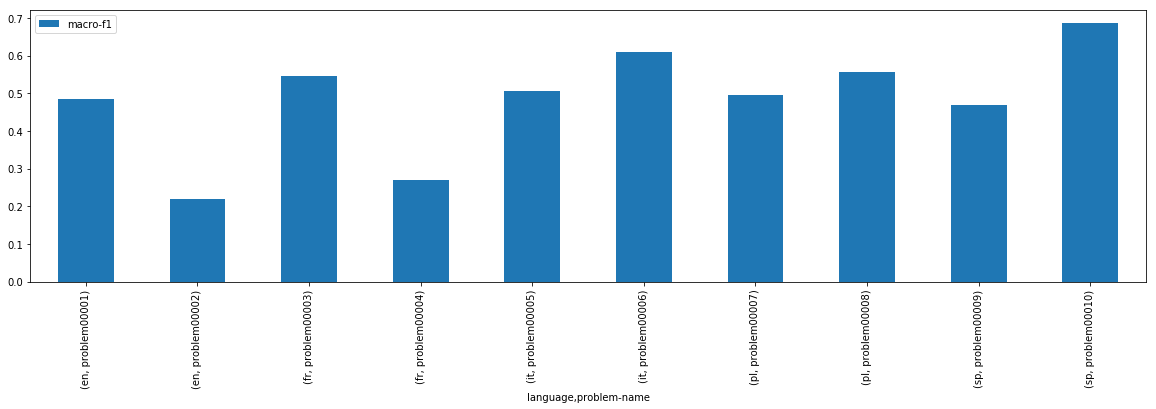

In [21]:
pd.DataFrame(result)\
    .sort_values(by=['language','problem-name'])[['language','problem-name','macro-f1']]\
    .plot(kind='bar', x=['language','problem-name'], legend=True, figsize=(20,5))

In [52]:
print(ObfuscationTransformer(re_from=r'\w',re_to='x').fit_transform(["Verdes mares bravios ç ç\n\n."])[0])

xxxxxx xxxxx xxxxxxx ç ç

.


In [55]:
print(problems[8]['candidates'][0][0][0:500])

pero no lo ama como ama a Guignol –explicó el niño sin sospechar las implicaciones inmorales de todo el cuento.

-¿Y cómo sabes que no lo ama? –Inglaterra se preguntó a su vez si habría un muñeco del esposo también.

-Francia me lo contó, dijo que era un romance –Canadá sonrió como si zanjara el asunto al nombrarlo-. ¿Sabe? Francia me los ha regalado, y se ha disculpado y luego me ha prometido muchos dulces y juegos y más dulces.

¿Francia había tenido la misma idea mucho antes que él? Qué desgr


In [56]:
print(ObfuscationTransformer(re_from=r'\w',re_to='x').fit_transform([problems[8]['candidates'][0][0][0:500]])[0])

xxxx xx xx xxx xxxx xxx x xxxxxxx –xxxxxxó xx xxñx xxx xxxxxxxxx xxx xxxxxxxxxxxxx xxxxxxxxx xx xxxx xx xxxxxx.

-¿x xóxx xxxxx xxx xx xx xxx? –xxxxxxxxxx xx xxxxxxxó x xx xxx xx xxxxíx xx xxñxxx xxx xxxxxx xxxxxéx.

-xxxxxxx xx xx xxxxó, xxxx xxx xxx xx xxxxxxx –xxxxxá xxxxxó xxxx xx xxxxxxx xx xxxxxx xx xxxxxxxxx-. ¿xxxx? xxxxxxx xx xxx xx xxxxxxxx, x xx xx xxxxxxxxxx x xxxxx xx xx xxxxxxxxx xxxxxx xxxxxx x xxxxxx x xáx xxxxxx.

¿xxxxxxx xxxíx xxxxxx xx xxxxx xxxx xxxxx xxxxx xxx éx? xxé xxxxx
